# [三次样条插值/cubic spline interpolation](https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation)

In [123]:
import numpy as np
from scipy.linalg import solve_banded
from bisect import bisect_left,bisect
import matplotlib.pyplot as plt

%matplotlib inline

## 问题
已知：
x: (n+1)*1; a, b = min(x), max(x)
y: (n+1)*1
求S(x), 满足:
  1. S(xi) = yi
  2. S(x) = Ci(x) for $x >= x(i-1)$ and x <= x(i+1), i = 1,2,3,...    
 
其中，$Ci(x) = ai + bi*x + ci*x^2 + di*x^3$，所以待确定参数有 n组，每组4个，共4n个参数
限制条件有：
1. 函数值：Ci(x(i-1)) = y(i-1), Ci(x(i)) = y(i) 
2. 一阶导数： C'i(xi) = C'(i+1)[xi]
3. 二阶导数：C''i(xi) = C''(i+1)[xi]
4. 边界点： C''(x0) = C''(xn) = 0
一阶导数表示除端点外的所有点i属于C[i]又属于C[i+1], 这两个函数在这个点的一阶导数相等

共n*2 + (n-1) + n-1 + 2 = 4n 个方程


In [184]:
x = [-1, 0, 3]
x = np.sort(x)
y = np.asarray([.5, 0, 3])

Text(0,0.5,'f')

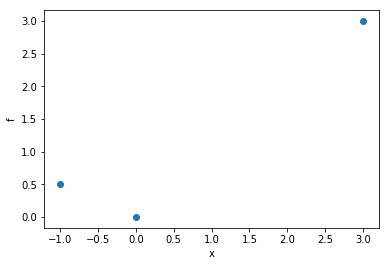

In [187]:
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('f')

In [205]:
c = CubicSpline(y, x)
c._test()
_x = [-.5,-.2, 0 ,.3,.6,1,2]
_y = [c.interpolate(v) for v in _x]

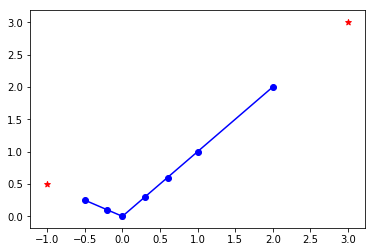

In [213]:
plt.plot(_x, _y, '-bo')
plt.scatter(x, y, c='r',marker='*')
# 怎么是直线呢？

In [209]:
class CubicSpline:
    def __init__(self,y,x,alpha=0, beta=0):
        # alpha 是min(x)处的二阶导数
        # beta 是max(x)处的二阶导数
        
        self.y = y
        self.x = x
        self.alpha = alpha
        self.beta = beta
        self.h = np.diff(x)
        Ms = self.cal_coef()

    def cal_coef(self):
        
        _h = self.h
        _h1 = _h[1:]
        _h = _h[:-1]
        _u = _h/(_h1 + _h)
        _lambda = 1 - _u
        _lambda = np.append(np.asarray([0]), _lambda)
        _u = np.append(_u, 0)
        self._u = _u
        self._lambda = _lambda
        d = np.zeros_like(self.x)
        for i in range(len(self.x)-2):
            d[i] = 6*_divi_dif(self.x[i:i+3], self.y[i:i+3])
        d[0] = self.alpha
        d[1] = self.beta
        self._d = d
        self.coef = tridiag(_u, 2*np.ones(len(self.x)), _lambda)
        Ms = solve_banded((1,1), diagonal_form(self.coef), d)
        self._Ms = Ms
        return Ms
        
    def interpolate(self, x):
        #Ms 为二阶导数值
        _i = bisect_left(self.x, x)
        m0, m1 = self._Ms[_i-1: _i+1]
        x0, x1 = self.x[_i-1: _i+1]
        y0, y1 = self.y[_i-1: _i+1]
        h = x1 - x0
        h6 = 6 * h
        x1x = x1 - x
        x0x = x - x0
        Ci_x = m0*x1x**3/h6 + m1*x0x**3/h6 + \
        (y0 - m0*h**2)*x1x/h + (y1 - m1*h**2/h)*(x0x/h)
        return Ci_x

    def _test(self):
        x = [-1, 0, 3]
        y = np.asarray([.5, 0, 3])
        c = CubicSpline(y, x)
        _x = [-.5,-.2, 0 ,.3,.6,1,2]
        _y = [c.interpolate(v) for v in _x]
        assert c.interpolate(3) == 3
        # todo other test

def divi_dif(x, f):
    """
    均差
    """
    if len(x) == 1:
        return f(x)
    else:
        _dif = (divi_dif(x[1:],f) - divi_dif(x[:-1], f))/(x[-1] - x[0])
        return _dif

def _divi_dif(x, y):
    if len(x) == 1:
        return y
    else:
        _dif = (_divi_dif(x[1:], y[1:]) - _divi_dif(x[:-1], y[:-1]))/(x[-1] - x[0])
        return _dif

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    _a = np.diag(a, k1)
    _b = np.diag(b, k2)
    _c = np.diag(c, k3)
    _d = _a + _b + _c
    return _d

def test_tridiag(verbose=True):
    a = np.asarray([[2,3,0],[1,1,1], [0,2,1]])
    b = tridiag([1,2], [2,1,1], [3,1])
    if verbose:
        print(a)
        print('tridiag:')
        print(b)
    assert np.allclose(a,b)

def test_divi_dif():
    x = np.asarray([1,2,4])
    x.sort()
    y = x**3
    return _divi_dif(x, y)

test_divi_dif()
test_tridiag(verbose=False)

In [121]:
def diagonal_form(a, upper = 1, lower= 1):
    """
    a is a numpy square matrix
    this function converts a square matrix to diagonal ordered form
    returned matrix in ab shape which can be used directly for scipy.linalg.solve_banded
    """
    n = a.shape[1]
    assert(np.all(a.shape ==(n,n)))
    
    ab = np.zeros((2*n-1, n))
    
    for i in range(n):
        ab[i,(n-1)-i:] = np.diagonal(a,(n-1)-i)
        
    for i in range(n-1): 
        ab[(2*n-2)-i,:i+1] = np.diagonal(a,i-(n-1))

    mid_row_inx = int(ab.shape[0]/2)
    upper_rows = [mid_row_inx - i for i in range(1, upper+1)]
    upper_rows.reverse()
    upper_rows.append(mid_row_inx)
    lower_rows = [mid_row_inx + i for i in range(1, lower+1)]
    keep_rows = upper_rows+lower_rows
    ab = ab[keep_rows,:]


    return ab

## cubic spline
- 主要是推导，实现比较容易  
divided difference


- 积分（用到了二阶导数相关的限制条件),求常数。Lagrange interpolation  
    得出C(x,M)的表达式
- 斜率相等 + 边界条件  
    得出M
- 将M带入到C(x, M)得出C(x), partional

---
## Lagrange interporlation/拉格朗日插值

$$L_j(x) := \sum\limits_{j=0}^{k}y_jl_j(x)$$

- 拉格朗日基本多项式
lagrange basis polynomials

$$l_j(x) := \prod\limits_{\substack{i \\ i \neq j}}^k \frac{x - x_j}{x_j - x_i}$$

不足：
- 是k-1次
- 不能增量计算。增加一个点需要重复计算所有$l_j(x)$， 可以cache?

$l_j(x)$ 在x = $x_j$时取1，在$x\neq x_j$时取0